In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [ ]:
def parallel_trees(m, fn, n_jobs=8):
    return list(ThreadPoolExecutor(n_jobs).map(fn, m.estimators_))

In [3]:
set_plot_sizes(12,14,16)

In [4]:
import feather
df_raw = feather.read_dataframe('tmp/bulldozers_raw')

In [5]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

In [8]:
set_rf_samples(50000)  # by "reset_rf_sample()" we can go back to use all the data 
#paper

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5
                          , n_jobs=-1, oob_score=True)# set the numbers from last time
m.fit(X_train, y_train)# fit دیتا رو رووش 
print_score(m)

[0.11072262157877102, 0.20659895020239544, 0.9766621461689596, 0.6249621294491472, 0.9111565866606377]


r_squerd of "second from right" on val_set is pretty good acording to data set size which we have used for traing , on aval aval

In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#go to untiteld

#start
np.mean(preds[:,0]), np.std(preds[:,0])# for item number zero  

Wall time: 1.53 s


(11.036602429888214, 0.20831722620537962)

In [ ]:
y_valid[0]

In [ ]:
preds.shape # n_estimators by n_valid

In [19]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds)) #paper
np.mean(preds[:,0]), np.std(preds[:,0])#paper

Wall time: 1.47 s


(11.036602429888214, 0.20831722620537962)

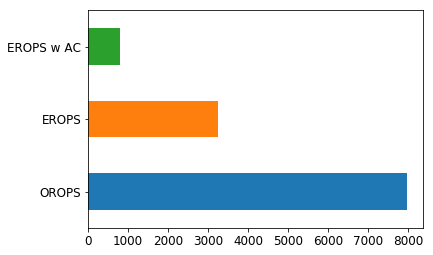

In [98]:
#statrt
x = raw_valid.copy()#paper

x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)#paper

x.Enclosure.value_counts().plot.barh();
# hamoon tor ke ghablan ham ghoftam 
# ie done jyper not dighr hast ke ghablan kol data ke oon aval note khondim 
#train shode roie ye super cump
#ke nemodar ha ro behtar neshon mide 


#oon ieki

#paper

In [99]:
x.Enclosure.value_counts()#end

OROPS         7972
EROPS         3243
EROPS w AC     784
Name: Enclosure, dtype: int64

In [100]:
#start
flds = ['Enclosure' , 'SalePrice', 'pred', 'pred_std']
#paper
enc_summ = x[flds].groupby('Enclosure' , as_index = False).mean()
enc_summ#paper

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.996246,9.905412,0.273584
1,EROPS w AC,10.235214,10.122719,0.299847
2,OROPS,9.972491,9.922448,0.276908


In [101]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)] 
#paper
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))#paper

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.996246,9.905412,0.273584
1,EROPS w AC,10.235214,10.122719,0.299847
2,OROPS,9.972491,9.922448,0.276908


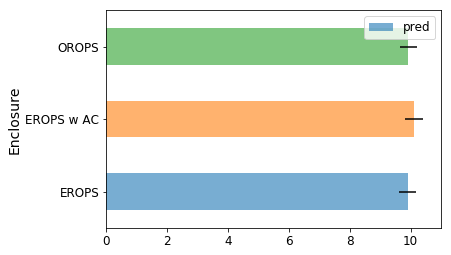

In [104]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11)) 
# using  {xerr=  column 'pred_std'} for error bar
#paper

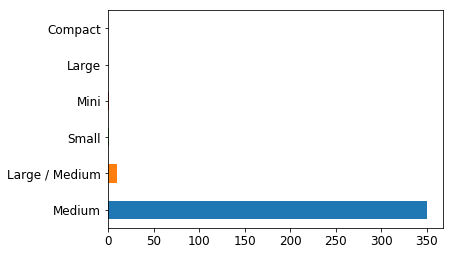

In [105]:
raw_valid.ProductSize.value_counts().plot()
#oon yeki

In [ ]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ
#paper

In [107]:
(enc_summ.pred_std / enc_summ.pred).sort_values(ascending = False)
#oon yeki
#paper

1    0.029621
2    0.027907
0    0.027620
dtype: float64

 so Erops has less confidence 

# feature importance 

In [108]:
fi = rf_feat_importance(m,df_trn);fi[:10]

,cols,imp
5,YearMade,0.158304
17,ProductGroupDesc,0.105252
16,ProductGroup,0.098940
14,fiProductClassDesc,0.065475
19,Enclosure,0.053537
35,Tire_Size,0.048563
13,ProductSize,0.045970
10,fiSecondaryDesc,0.032257
63,saleElapsed,0.031920
39,Hydraulics_Flow,0.029119


In [109]:
fi.loc[fi.index[23]].imp  # treshold , where bars are flattend out in figure below 

0.005908259972667595

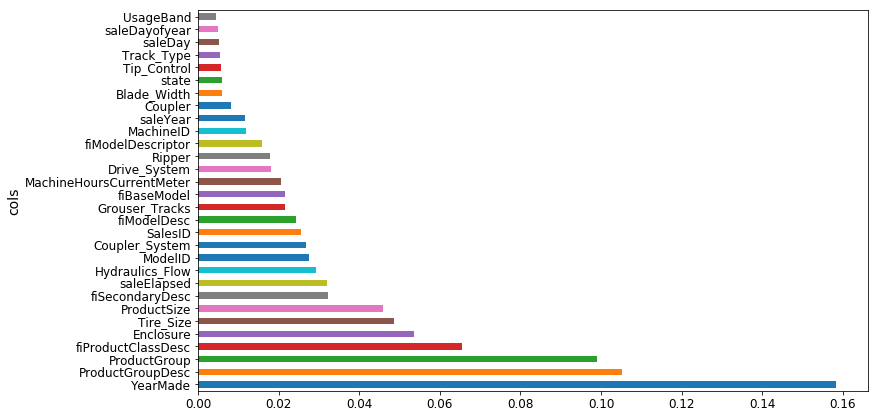

In [110]:
fi[:30].plot('cols','imp','barh',figsize=(12,7),legend=False);

In [111]:
fi.loc[24]

cols    Transmission
imp       0.00174869
Name: 24, dtype: object

In [112]:
to_keep = fi[:24].cols  ; len(to_keep)  # can write (to_keep = fi[fi.imp>0.005].cols)

24

In [113]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [114]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12255062763674479, 0.19206339290353242, 0.9714096629652413, 0.6758783085783672, 0.9107786171814806]


In [115]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

### the figure below is like this because the importance was distributed between redundant , removed features 

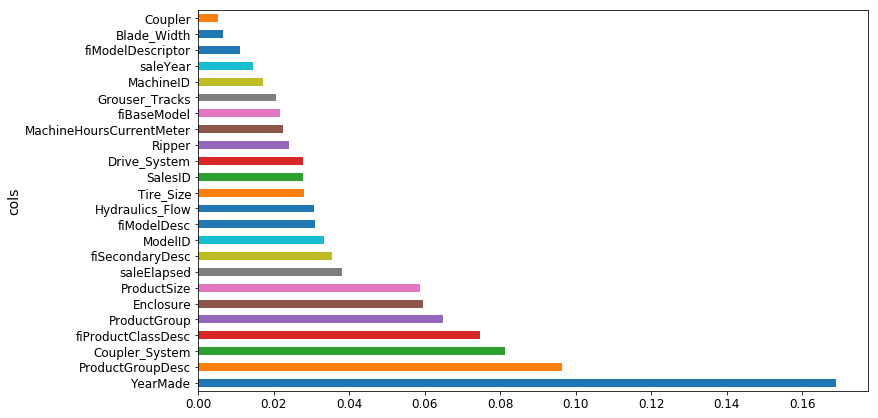

In [116]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# one_hot_encoding

In [117]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.10926249016184225, 0.19602045238381882, 0.977273613741499, 0.6623850436791043, 0.9099128096924438]


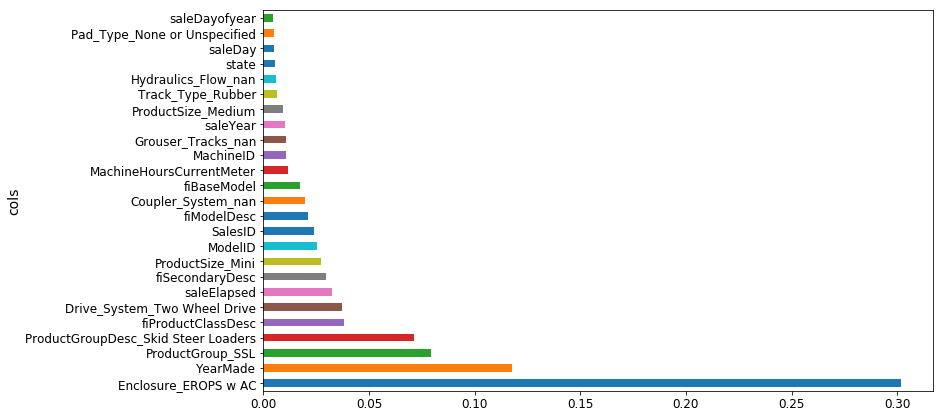

In [118]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi[:25]);

In [119]:
to_keep_1hot = fi[:21].cols

# Removing redundant features

In [120]:
from scipy.cluster import hierarchy as hc

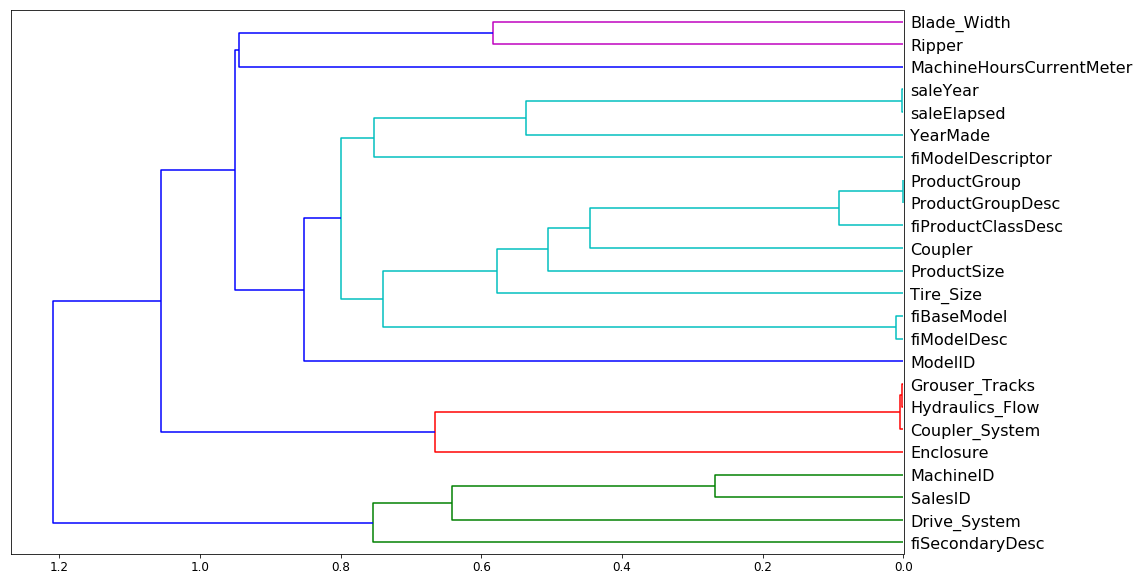

In [121]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [122]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [123]:
get_oob(df_keep)

C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9015981572784189

# here in three cases we are getting better result by dropping

In [124]:
for c in ['saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks','Hydraulics_Flow', 'Coupler_System']:
    print(c, get_oob(df_keep.drop(c, axis=1)))

C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleYear 0.8904889738089894


C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


saleElapsed 0.889587897183484


C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


fiModelDesc 0.9035439328138356


C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


fiBaseModel 0.8905121920291339


C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Grouser_Tracks 0.9033809785490114
Hydraulics_Flow 0.9074736318892088


C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


Coupler_System 0.8991134343905448


In [125]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.9059600788622978

In [126]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [127]:
reset_rf_samples()

In [128]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1354691092958048, 0.20538909238050784, 0.9650643565875219, 0.6293417637785943, 0.9109922682272943]


# for one_hot_encoded

In [129]:
df_keep_1hot_encoded = df_trn2[to_keep_1hot].copy()

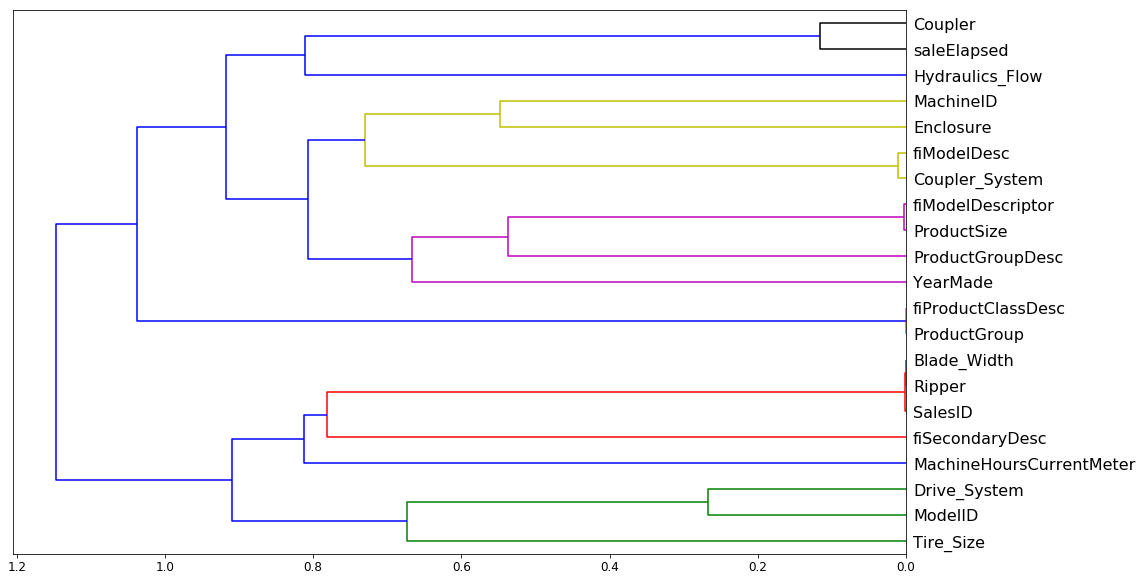

In [130]:
corr = np.round(scipy.stats.spearmanr(df_keep_1hot_encoded).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [131]:
col = list(df_keep_1hot_encoded.columns)

In [132]:
col

['Enclosure_EROPS w AC',
 'YearMade',
 'ProductGroup_SSL',
 'ProductGroupDesc_Skid Steer Loaders',
 'fiProductClassDesc',
 'Drive_System_Two Wheel Drive',
 'saleElapsed',
 'fiSecondaryDesc',
 'ProductSize_Mini',
 'ModelID',
 'SalesID',
 'fiModelDesc',
 'Coupler_System_nan',
 'fiBaseModel',
 'MachineHoursCurrentMeter',
 'MachineID',
 'Grouser_Tracks_nan',
 'saleYear',
 'ProductSize_Medium',
 'Track_Type_Rubber',
 'Hydraulics_Flow_nan']

In [133]:
for c in ['Coupler_System_nan','fiSecondaryDesc','MachineHoursCurrentMeter','SalesID', 'saleElapsed', 
          'fiModelDesc', 'Drive_System_Two Wheel Drive', 'ProductSize_Medium','ProductSize_Mini','fiProductClassDesc']:
    print(c, get_oob(df_keep_1hot_encoded.drop(c, axis=1)))

Coupler_System_nan 0.9033794533941113
fiSecondaryDesc 0.9008562781269953
MachineHoursCurrentMeter 0.9024367443527386
SalesID 0.903514958532024
saleElapsed 0.9005241614208939
fiModelDesc 0.9011842118344712
Drive_System_Two Wheel Drive 0.902437887190606
ProductSize_Medium 0.9025438986242736
ProductSize_Mini 0.8988595815934503
fiProductClassDesc 0.8936763195930463


# partial dependence 

In [134]:
from pdpbox import pdp
from plotnine import *

ModuleNotFoundError: No module named 'pdpbox'

In [135]:
set_rf_samples(50000)

In [136]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

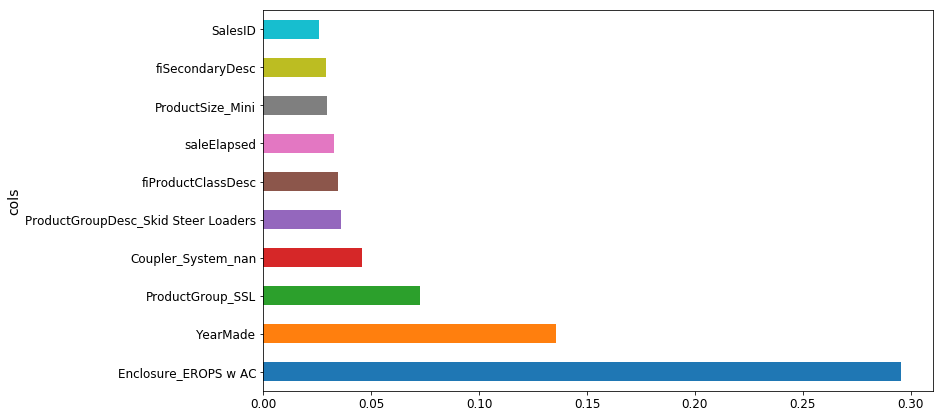

In [137]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

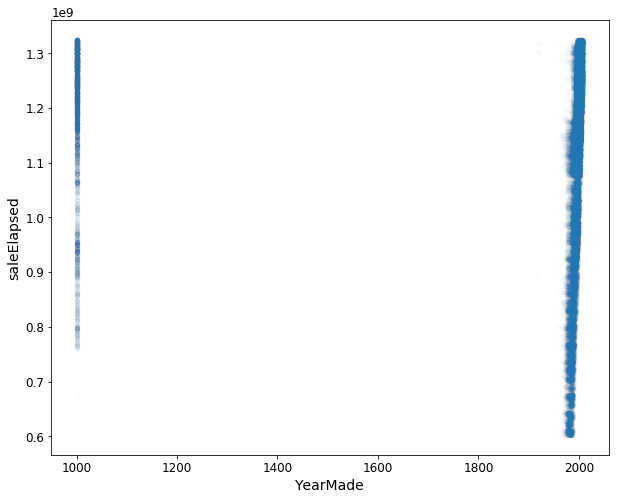

In [138]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8))

In [139]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [140]:
np.random.permutation(10)

array([9, 1, 6, 7, 5, 4, 0, 3, 8, 2])

In [141]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

NameError: name 'ggplot' is not defined

# in figure above we could not remove the effect of other things except for YearMade on SalePrice but in figure below we can 

In [ ]:
x_all.YearMade.max()

In [ ]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [ ]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

## it will replace the YearMade of every rows by one year and plot the points of that then another year ...

In [ ]:
plot_pdp('YearMade')

In [ ]:
plot_pdp('YearMade', clusters=5) # 5 main treatment of figure above 

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

In [ ]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [ ]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

## treeinterpreter : which feature lead our prediction to be this 

In [ ]:
from treeinterpreter import treeinterpreter as ti

In [ ]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [ ]:
row = X_valid.values[None,0]; row

In [ ]:
type(X_valid)

In [ ]:
type(X_valid.values)

In [ ]:
prediction, bias, contributions = ti.predict(m, row)

In [ ]:
prediction[0], bias[0]

In [ ]:
idxs = np.argsort(contributions[0]) # if that were sorted , the indexes would be "idxs" list

In [ ]:
X_valid.loc[39956]

In [ ]:
X_valid.iloc[0]

In [ ]:
X_valid.values[0]

In [ ]:
type(X_valid.iloc[0])

In [ ]:
type(X_valid.values[0])

In [ ]:
[o for o in zip(df_keep.columns[idxs], df_valid.values[0][idxs], contributions[0][idxs])]

In [ ]:
contributions[0].sum()

# Extrapolation

### in time series data usualy , when our test and validation set is so different from our training set , this technic is neccesary 

In [142]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [143]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)

In [144]:
m.fit(x,y)
m.oob_score_

0.9999807529447995

so our validation set is not a random subset of data 

In [145]:
fi = rf_feat_importance(m,x);fi[:10]

,cols,imp
12,SalesID,0.681962
7,fiSecondaryDesc,0.132836
3,fiProductClassDesc,0.065373
1,ProductGroupDesc,0.031491
10,ModelID,0.021123
18,MachineID,0.018147
0,YearMade,0.015458
13,fiModelDesc,0.013766
2,ProductGroup,0.006829
15,Drive_System,0.005525


In [146]:
feats = fi[:2].cols;feats

12            SalesID
7     fiSecondaryDesc
Name: cols, dtype: object

In [147]:
(X_train[feats]/1000).describe()

,SalesID,fiSecondaryDesc
count,39956.000000,39956.000000
mean,1213.885627,0.017908
std,45.923399,0.022991
min,1139.246000,0.000000
25%,1173.086250,0.000000
50%,1208.233500,0.015000
75%,1261.361500,0.026000
max,1279.679000,0.103000


In [148]:
(X_valid[feats]/1000).describe()

,SalesID,fiSecondaryDesc
count,12000.000000,12000.000000
mean,1287.572126,0.043813
std,4.374811,0.023127
min,1279.680000,0.000000
25%,1283.714750,0.036000
50%,1287.599500,0.037000
75%,1291.517250,0.075000
max,1294.841000,0.077000


In [149]:
x.drop(feats, axis=1, inplace=True)

In [150]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9857764262067904

In [151]:
X_train , X_valid = split_vals(df_keep.drop(feats,axis=1), n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13542527684671463, 0.18577750335369353, 0.9650869605166804, 0.6967469709006893, 0.9060654918647588]


In [152]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,YearMade,0.172685
1,ProductGroupDesc,0.146195
2,ProductGroup,0.090953
4,Enclosure,0.070174
3,fiProductClassDesc,0.070023
6,ProductSize,0.059867
7,saleElapsed,0.051778
9,ModelID,0.049403
10,Coupler_System,0.048096
11,fiModelDesc,0.047131


In [153]:
set_rf_samples(50000)

In [154]:
feats = fi[:5].cols;feats

0              YearMade
1      ProductGroupDesc
2          ProductGroup
4             Enclosure
3    fiProductClassDesc
Name: cols, dtype: object

In [155]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1252068388131513, 0.21526691793761776, 0.9701568750758448, 0.5928321403082175, 0.9099251440050949]


In [161]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

YearMade
[0.14082990999762088, 0.2674245849460655, 0.9622446936191762, 0.3716211426682128, 0.8862653850919038]


C:\Users\Lenovo\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


ProductGroupDesc
[0.12424335454210202, 0.2002657370638023, 0.9706144020140455, 0.6476029939419707, 0.9049970667594288]
ProductGroup
[0.12399480226442394, 0.20219815541338593, 0.9707318578176599, 0.6407694344564118, 0.9098568710544701]
Enclosure
[0.12728037414823348, 0.2093856531823379, 0.969160233444391, 0.6147765241722776, 0.9074796275965761]
fiProductClassDesc
[0.1265365825794183, 0.22937579709242964, 0.9695196185540983, 0.537710440923961, 0.9067897783533075]


## we should drop features which make our val_set loss wore

In [163]:
df_subs = df_keep.drop(['ProductGroupDesc', 'ProductGroup', 'Enclosure'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1270480240644712, 0.199821346056875, 0.9692727265443722, 0.6491652013584293, 0.9075156734449826]


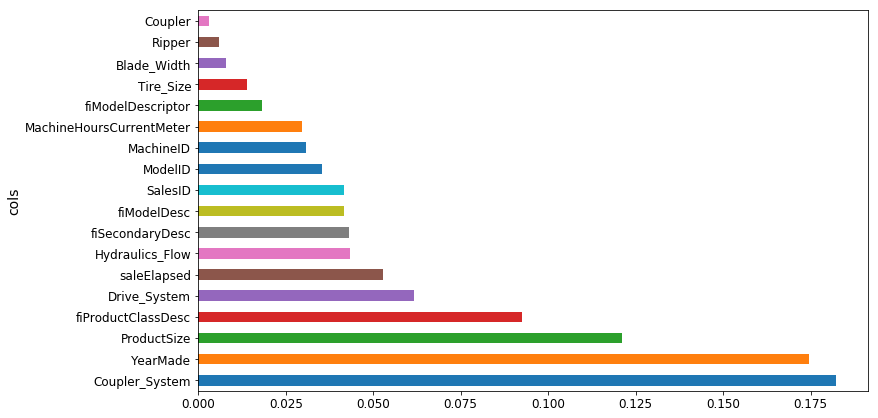

In [164]:
plot_fi(rf_feat_importance(m, X_train));

# Final model

In [165]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 10.9 s
[0.061267406017800154, 0.1982697877458616, 0.9928542604653994, 0.6545923224334604, 0.9139886952551193]
